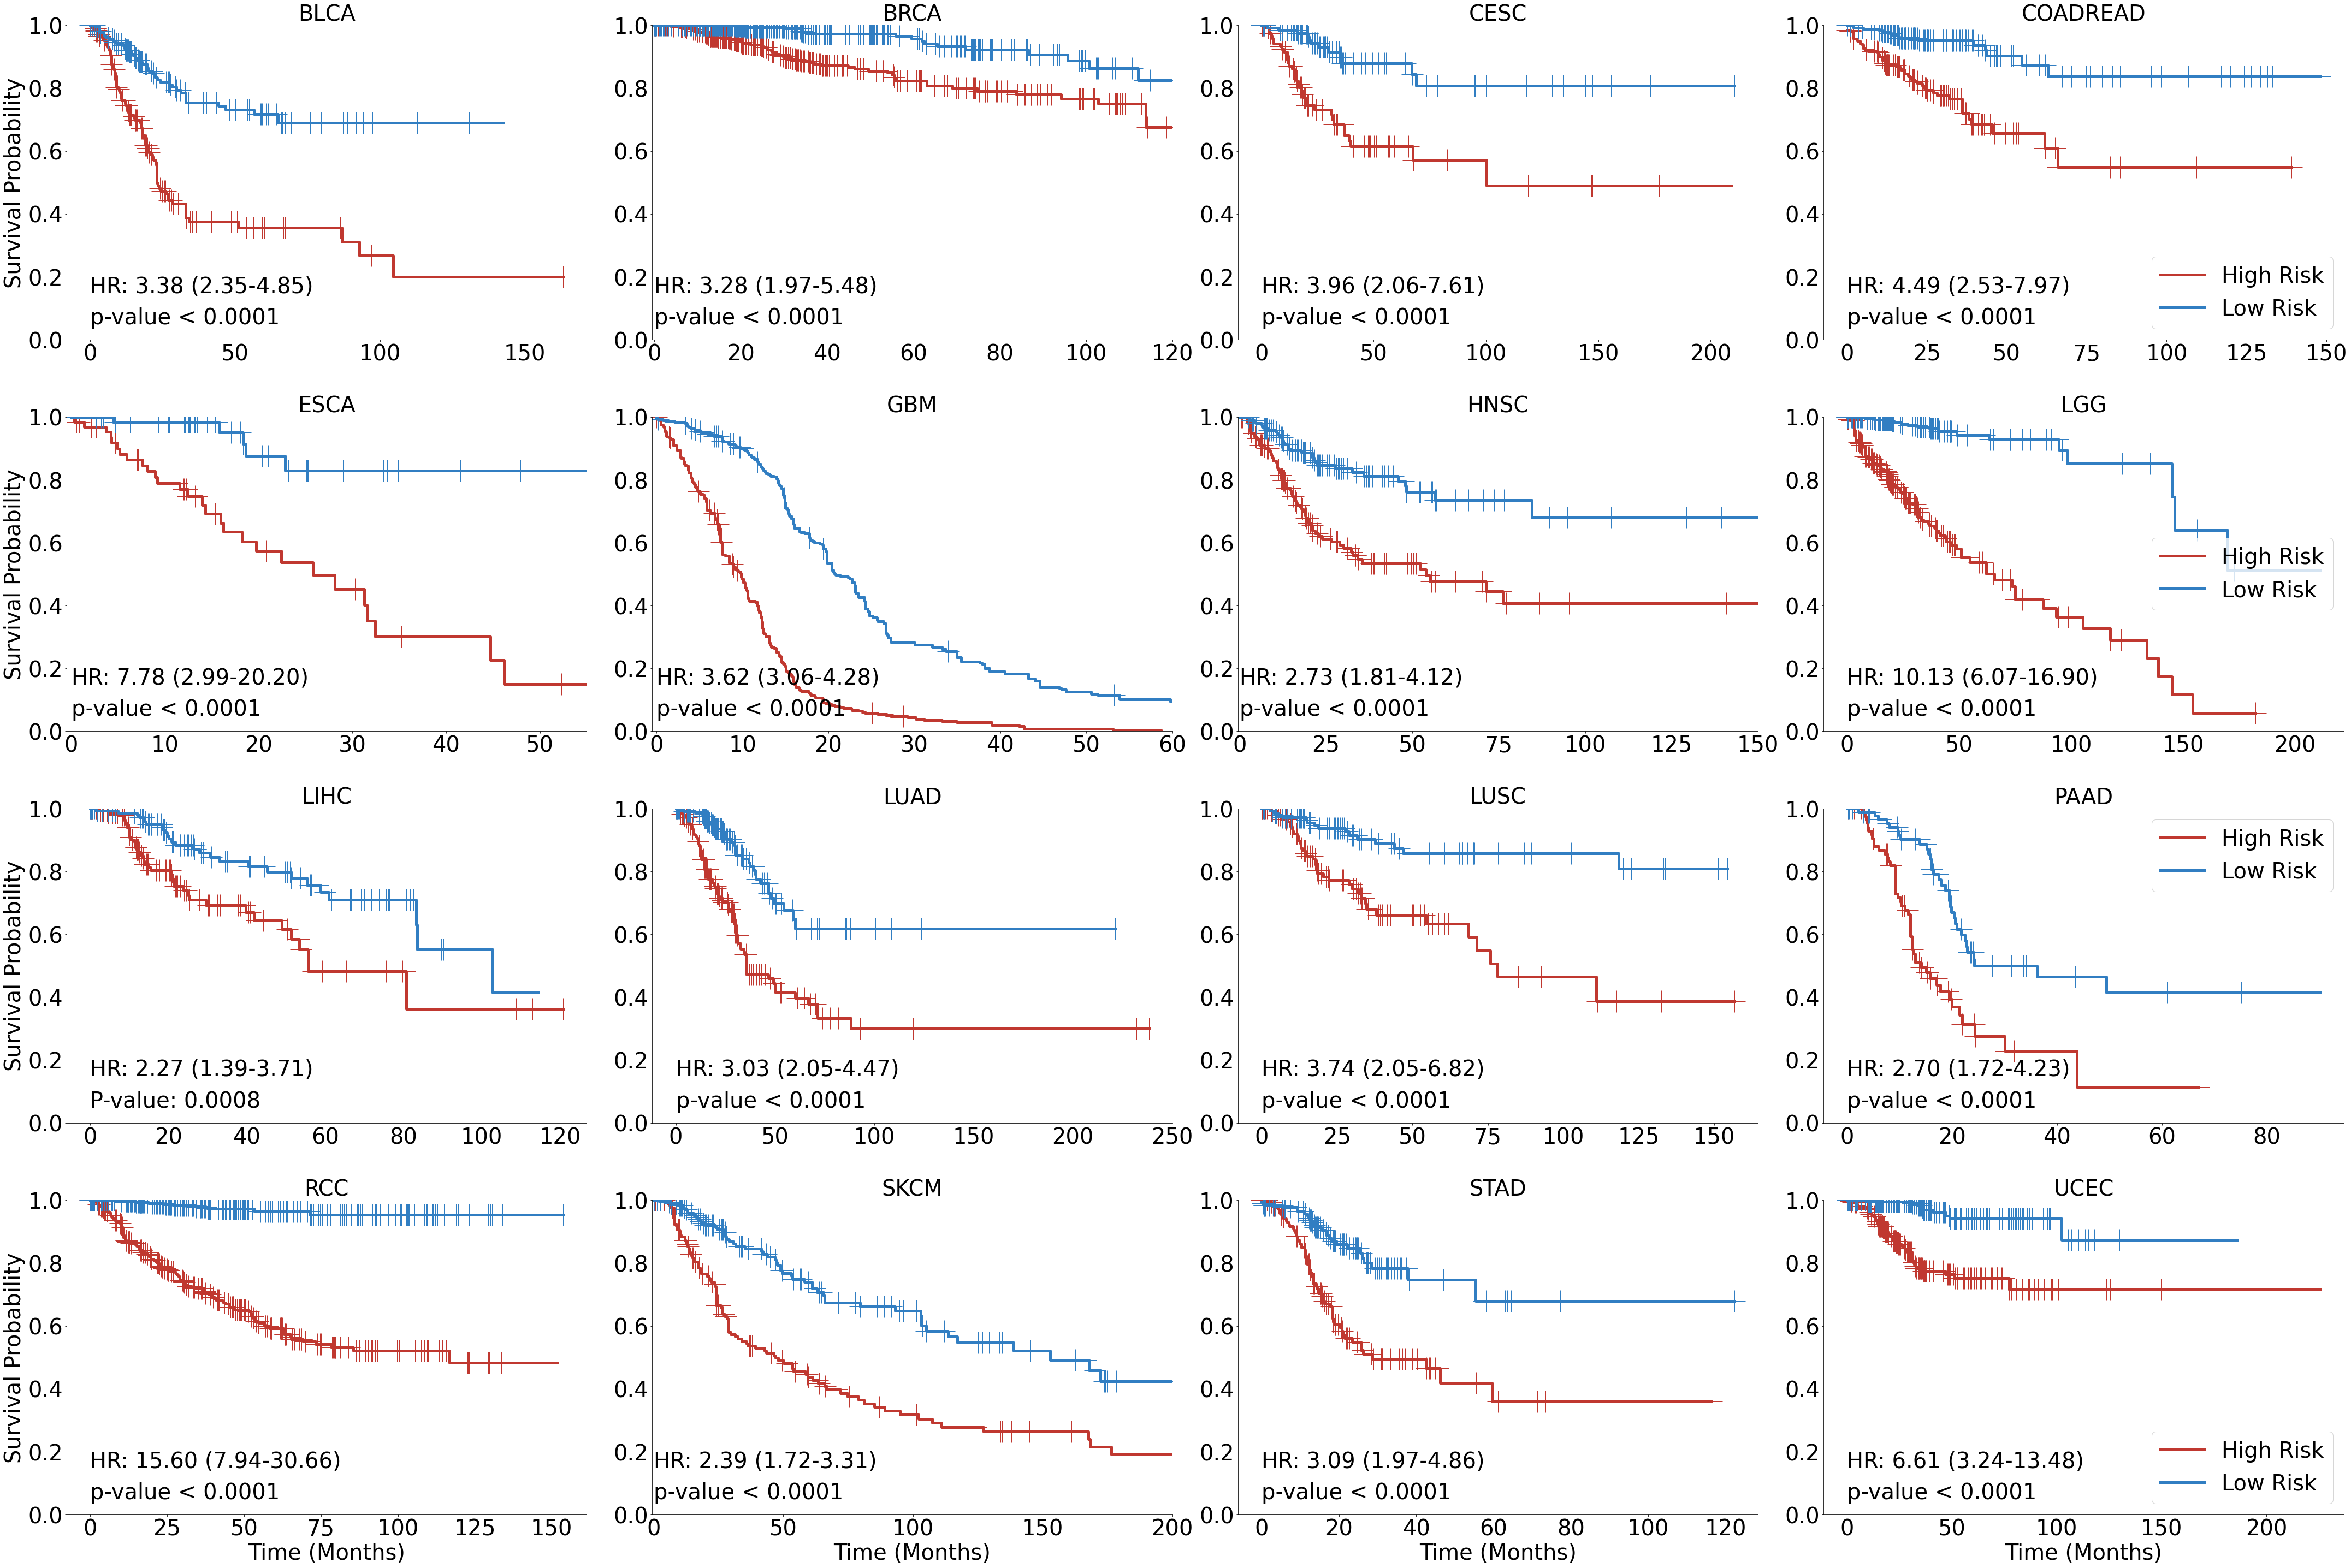

In [1]:

import pandas as pd
from lifelines import KaplanMeierFitter, CoxPHFitter  
import matplotlib.pyplot as plt
import torch
from lifelines.statistics import logrank_test
import numpy as np 


projects = ['blca', 'brca', 'cesc', 'coadread', 'esca', 'gbm', 'hnsc', 'lgg', 'lihc', 'luad', 'lusc', 'paad', 'rcc', 'skcm', 'stad', 'ucec']
data_roots = [f"./workspace/models/config_clam_coxreg_musk/tcga_{proj}" for proj in projects]

fig, axs = plt.subplots(4, 4, figsize=(60, 40))  # Adjust size as needed
axs = axs.ravel()  # Flatten the array for easy indexing

for idx, data_root in enumerate(data_roots):

    dfs = []
    cindex_list = []

    for fold in range(5):
        
        data_dir = f"{data_root}/fold_{fold}"
        pfs = torch.load(f"{data_dir}/pfs.pt").cpu()
        risk = torch.load(f"{data_dir}/risk.pt").squeeze().cpu()
        status = torch.load(f"{data_dir}/status.pt").cpu()

        # Assuming `df` is your DataFrame with 'time', 'status', and 'predicted_risk' columns
        # Sample data setup
        df = pd.DataFrame({
            'time': pfs,
            'status': status,
            'predicted_risk': risk
        })

        # Stratify patients into two groups based on the median risk score
        median_risk = df['predicted_risk'].median()
        df['risk_group'] = df['predicted_risk'].apply(lambda x: 'High' if x > median_risk else 'Low')

        dfs.append(df)

    # concatenate all dataframes from different groups
    combined_df = pd.concat(dfs)

    # Perform the log-rank test
    results = logrank_test(
        durations_A=combined_df.loc[combined_df['risk_group']=='High', 'time'], 
        event_observed_A=combined_df.loc[combined_df['risk_group']=='High', 'status'],
        durations_B=combined_df.loc[combined_df['risk_group']=='Low', 'time'], 
        event_observed_B=combined_df.loc[combined_df['risk_group']=='Low', 'status']
        )

    p_value = results.p_value

    # ---------------- Hazard Ratio ----------------- #
    # Fit Cox model
    cph = CoxPHFitter()
    cph.fit(combined_df, duration_col='time', event_col='status', formula='risk_group')
   # Extract the hazard ratio for the high risk group (inverted)
    hr = 1 / cph.summary.loc['risk_group[T.Low]', 'exp(coef)']
    hr_ci_lower = 1 / cph.summary.loc['risk_group[T.Low]', 'exp(coef) upper 95%']
    hr_ci_upper = 1 / cph.summary.loc['risk_group[T.Low]', 'exp(coef) lower 95%']

    hr_text = f'HR: {hr:.2f} ({hr_ci_lower:.2f}-{hr_ci_upper:.2f})'

    # Initialize the KaplanMeierFitter model
    kmf = {'High': KaplanMeierFitter(), 'Low': KaplanMeierFitter()}
    label_name = {'High': "High Risk", "Low": "Low Risk"}
    color_dct = {'High':'#C03830', 'Low':'#317EC2'}

    # Plot KM curves for each group
    # fig, ax = plt.subplots()
    for name, grouped_df in combined_df.groupby('risk_group'):
        kmf[name].fit(durations=grouped_df["time"], event_observed=grouped_df["status"], label=label_name[name])
        kmf[name].plot_survival_function(ax=axs[idx], ci_show=False, show_censors=True, c=color_dct[name], linewidth=5)

    pvalue_text = f'P-value: {p_value:.4f}' if p_value > 0.0001 else 'p-value < 0.0001'
    
    fontsize = 40

    axs[idx].set_title(f'{projects[idx].upper()}', fontsize=fontsize)
    axs[idx].text(0, 0.05, pvalue_text, fontsize=fontsize)
    axs[idx].text(0, 0.15, hr_text, fontsize=fontsize)

    axs[idx].set_ylim([0, 1])
    
    # >>>>>>>>> cutoff the x axis >>>>>>>>> #
    if projects[idx].upper() == 'GBM':
        axs[idx].set_xlim([-0.5, 60])
    if projects[idx].upper() == 'SKCM':
        axs[idx].set_xlim([-0.5, 200])
    if projects[idx].upper() == 'HNSC':
        axs[idx].set_xlim([-0.5, 150])
    if projects[idx].upper() == 'BRCA':
        axs[idx].set_xlim([-0.5, 120])
    if projects[idx].upper() == 'ESCA':
        axs[idx].set_xlim([-0.5, 55])
    # <<<<<<<<< cutoff the x axis <<<<<<<<< #

    axs[idx].spines[['right', 'top']].set_visible(False)
    axs[idx].tick_params(axis='both', which='major', labelsize=fontsize)

    # if idx == 7:
    if idx == 3:
        axs[idx].legend(fontsize=fontsize, loc='lower right')
    elif idx == 7:
        axs[idx].legend(fontsize=fontsize, loc='center right')
    elif idx == 11:
        axs[idx].legend(fontsize=fontsize, loc='upper right')
    elif idx == 15:
        axs[idx].legend(fontsize=fontsize, loc='lower right')
    else:
        axs[idx].get_legend().set_visible(False)


    # if idx in range(8, 16):
    if idx in range(12, 16):
        axs[idx].set_xlabel('Time (Months)', fontsize=fontsize)
    else:
        axs[idx].set_xlabel(' ', fontsize=fontsize)

    # if idx in [0, 8]:
    if idx in [0, 4, 8, 12]:
        axs[idx].set_ylabel('Survival Probability', fontsize=fontsize)


# Adjust layout
plt.tight_layout()
plt.show()